In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt

# KNN imputer pour remplacer NaN
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer 

# DeepAR
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# params plt
plt.rcParams["figure.figsize"] = (15,5)
# plt.rcParams['axes.facecolor'] = '#262833'
plt.rcParams['font.size'] = 17
plt.style.use('fivethirtyeight')

# params dataframe
pd.set_option('display.float_format', lambda x: '%.2f' % x) # format des lignes virgules

##### 1. Premier import + drop duplicates
# na_values = "", "#N/A", "#N/A N/A", "#NA", "-1.#IND", "-1.#QNAN", "-NaN", "-nan", "1.#IND", "1.#QNAN", "<NA>", "N/A", "NA", "NULL", "NaN", "n/a", "nan", "null" , "?"
# df_raw = pd.read_csv("data/household_power_consumption.csv", delimiter=";", na_values=na_values, parse_dates=[['Date', 'Time']])
# df_raw = df_raw.drop_duplicates()

##### 2. Fusionner colonnes Date et Time + Convertir (gérer à l'import) + Trier date par odre croissant 
# parse_dates=[['Date', 'Time']]
# data = data.sort_values(by="Date_Time")

##### 3. Export du csv pour optimiser le temps de calcul
# data.to_csv('data/NEWhousehold_power_consumption.csv', sep='|', index=False)

##### 4. import final + passer en index
df_raw = pd.read_csv("data/KNNhousehold_power_consumption.csv", delimiter="|", parse_dates=['Date_Time'], index_col='Date_Time')
data = df_raw

##### 5. Gestion des NaN et Null (Moyenne)

##### 6. Gestion des NaN et Null (Simple imputer en mean)
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# data_SI = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

##### 7. Gestion des NaN et Null (drop)


##### 5. Gestion des NaN et Null (Drop = 25979 lignes)
# data = data.dropna(how = 'any')

# pd.set_option('display.float_format', lambda x: '%.2f' % x) 

data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.22,0.42,234.84,18.40,0.00,1.00,17.00
2006-12-16 17:25:00,5.36,0.44,233.63,23.00,0.00,1.00,16.00
2006-12-16 17:26:00,5.37,0.50,233.29,23.00,0.00,2.00,17.00
2006-12-16 17:27:00,5.39,0.50,233.74,23.00,0.00,1.00,17.00
2006-12-16 17:28:00,3.67,0.53,235.68,15.80,0.00,1.00,17.00


# Brief : Développez un outil de prévision de la consommation d'énergie

_L'objectif de ce projet est de créer un outil de prédiction de la consommation d'énergie en utilisant des réseaux neuronaux récurrents et anticiper les besoins du marché en termes d'énergie._


**Contexte du projet**

Vous travaillez dans l'équipe data d'un fournisseur d'éléctricité qui cherche à se moderniser avec des outils d'Intelligence Artificielle.   

Première source de donnée : 
vous permettra de vous initier aux prévisions sur la consommation d'une maison. 


Deuxième source :  
contient une base de données proche de la réalité avec la consommation de plusieurs maisons.

C'est à vous de décider comment vous allez utiliser ces données pour réaliser votre modèle de prédiction. 


**Modalités d'évaluation**<br> 
* Présentation orale - 20 min (Q/A inclus) / présentation en équipe.
* Pré-planning du projet
* Code review via github

**Critères de performance**<br> 
* compréhension du jeux de données
* performance des modèles de prédiction
* capacité à apporter une solution dans le temps imparti
* qualité du synthèse du travail

### Le dataset 1

Context: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.<br>  
This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).  
Notes:
* 1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
* 2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.<br> <br>    
 
**Attribute Information:**  
* 1.date: Date in format dd/mm/yyyy
* 2.time: time in format hh:mm:ss
* 3.globalactivepower: household global minute-averaged active power (in kilowatt)
* 4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)
* 5.voltage: minute-averaged voltage (in volt)
* 6.global_intensity: household global minute-averaged current intensity (in ampere)
* 7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
* 8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
* 9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# EDA

In [ ]:
imputer = KNNImputer()
data_KNN = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# data_KNN.isnull().sum()

In [ ]:
#Autre technique avec la moyenne en plus
mean_value=gfg['Global_active_power'].mean() 
  
data['Global_active_power'].fillna(value=mean_value, inplace=True) 

data

## Premières infos / Duplicates / NaN missing values

In [ ]:
data.info()
# Date et Time sont en object / Le reste en float64

In [ ]:
df_raw.describe()

In [ ]:
# df_raw.isnull().sum()
# df_raw.isna().sum()
data_null = df_raw[df_raw['Global_active_power'].isnull()]
data_null

## Outliers

## Distributions

C:\Users\Utilisateur\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Utilisateur\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

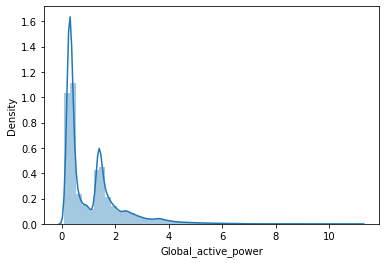

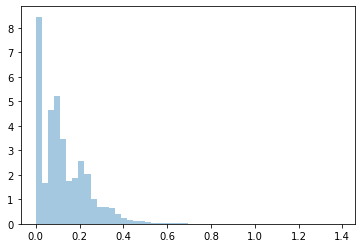

In [2]:
# Distribution gaussienne pour toutes les features (RAS)
# Operating Profit Rate / Operating Expense Rate (beaucoup de zero)

# df['Net Income Flag'].value_counts() = Il n'y a que des 1 / drop

# Liability-Assets Flag = 0.14 de corrélation / 8 valeur en 1 dont 6 qui influence bankrupt en 1 / On laisse la colonne pour l'instant
# df_new = df[(df['Interest-bearing debt interest rate']>0.01) & (df['Liability-Assets Flag']<0.99)]
# df_new = df 
# print(df_new['Liability-Assets Flag'].value_counts())
# print(df_new['Bankrupt?'].value_counts())
# print(df_new.shape)


for col in df_raw:
    plt.figure()
    sns.distplot(df_raw[col], kde=True)

## Corrélations / Feature selection / permutation

In [2]:
df_raw.corr().style.background_gradient(cmap='coolwarm')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


## Scaling

## Encoding

# Modèle deep learning : LSTM DEEP AR

### Explications

https://www.quantmetry.com/blog/previsions-probabilistes-deepar/  
An autoregressive recurrent neural net developed at Amazon  

Il n’est plus question de savoir que la consommation énergétique d’un logement donné sera de 60 kWh demain mais plutôt qu’il y a 95% de chance que cette consommation se trouve entre 58 et 61 kWh. Les intervalles de confiance deviennent les nouveaux objectifs des modèles car ils permettent d’estimer les valeurs extrêmes, souvent principale motivation d’une prise de décision.  
Récemment, de nouvelles méthodes de prédiction se sont développées afin de produire des modèles de prévision probabilistes. Parmi elles on trouve DeepAR, une méthodologie développée par Amazon AI dont le but est de produire des prévisions probabilistes grâce à un réseau de neurone autorégressif et récurrent entraîné sur une multitude de séries temporelles connexes.  

Il est important de noter la dépendance chronologique des séries temporelles : la valeur de la série à un instant donné n’est pas indépendante de son passé.
Différentes prévisions peuvent être produites à l’échelle d’une entreprise. Selon les exigences, plusieurs paramètres sont à déterminer :

* l’horizon temporel des prédictions : jour, semaine, mois, année, etc.
* la maille produit : modèle, article, gamme, quantités par magasin, etc.
* la maille géographique : continent, pays, région, etc.  

Ces paramètres sont critiques car ils définissent directement les différents modèles qu’il peut être pertinent d’utiliser pour obtenir les prévisions les plus justes.  

Dans le cas des prévisions probabilistes, on ne s’intéresse plus tant à prévoir un comportement moyen de la série temporelle étudiée, mais plutôt à quantifier la probabilité d’un événement extrême. L’estimation de l’incertitude permet de créer des intervalles de confiance ou des fonctions quantiles, outils indispensables à la prise de décision.  


### Modèle DEEP AR

https://aws.amazon.com/fr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/    
  
**Amazon Sagemaker : solution en AI and Machine Learning (produit Amazon)**  
_Amazon SageMaker aide les scientifiques et les développeurs de données à préparer, construire, former et déployer rapidement des modèles d'apprentissage automatique de haute qualité en rassemblant un large éventail de fonctionnalités conçues spécialement pour l'apprentissage automatique.  
Vous pouvez utiliser SageMaker pour former et déployer un modèle à l'aide d'un code MXNet personnalisé._  
<br><br>
**Gluon Time Series (GluonTS) (release 2019)**  
_a Python toolkit open source developed by Amazon scientists for building, evaluating, and comparing deep learning–based time series models. GluonTS is based on the Gluon interface to Apache MXNet and provides components that make building time series models simple and efficient._  
GluonTS est livré avec des modèles de prévision probabiliste préconstruits. Au lieu de simplement prédire une estimation ponctuelle, la prévision probabiliste attribue une probabilité à chaque résultat.  
<br>  <br>
**Méthode probabiliste**  
Il n’est plus question de savoir que la consommation énergétique d’un logement donné sera de 60 kWh mais plutôt qu’il y a 95% de chance que cette consommation se trouve entre 58 et 61 kWh.   
Les intervalles de confiance deviennent les nouveaux objectifs des modèles car ils permettent d’estimer les valeurs extrêmes, souvent principale motivation d’une prise de décision.  

Il est important de noter la dépendance chronologique des séries temporelles : la valeur de la série à un instant donné n’est pas indépendante de son passé.
Différentes prévisions peuvent être produites à l’échelle d’une entreprise. Selon les exigences, plusieurs paramètres sont à déterminer :

* l’horizon temporel des prédictions : jour, semaine, mois, année, etc.
* la maille produit : modèle, article, gamme, quantités par magasin, etc.
* la maille géographique : continent, pays, région, etc.  

Ces paramètres sont critiques car ils définissent directement les différents modèles qu’il peut être pertinent d’utiliser pour obtenir les prévisions les plus justes.  

Dans le cas des prévisions probabilistes, on ne s’intéresse plus tant à prévoir un comportement moyen de la série temporelle étudiée, mais plutôt à quantifier la probabilité d’un événement extrême. L’estimation de l’incertitude permet de créer des intervalles de confiance ou des fonctions quantiles, outils indispensables à la prise de décision.  
<br><br>
**DeepAR (GluonTS toolkit) – Autoregressive Recurrent Network / A supervised learning algorithm for forecasting scalar time series using Recurrent Neural Networks (RNN)**  
_DeepAR est une méthodologie qui permet d’obtenir un modèle global de prévision basé sur un réseau de neurones autorégressif et récurrent. Le modèle est autorégressif car l’observation z du dernier pas de temps est utilisée comme entrée du réseau au pas de temps suivant et récurrent car la sortie du réseau h à un instant donné est réinjectée dans le réseau à l’instant suivant. (cf. notation Figure 2.)  
Une méthodologie développée par Amazon AI dont le but est de produire des prévisions probabilistes grâce à un réseau de neurone autorégressif et récurrent entraîné sur une multitude de séries temporelles connexes.  
Pour que l’apprentissage soit efficace, au moins 200 séries temporelles doivent être disponibles et elles doivent être générées par un même processus ou des processus similaires._


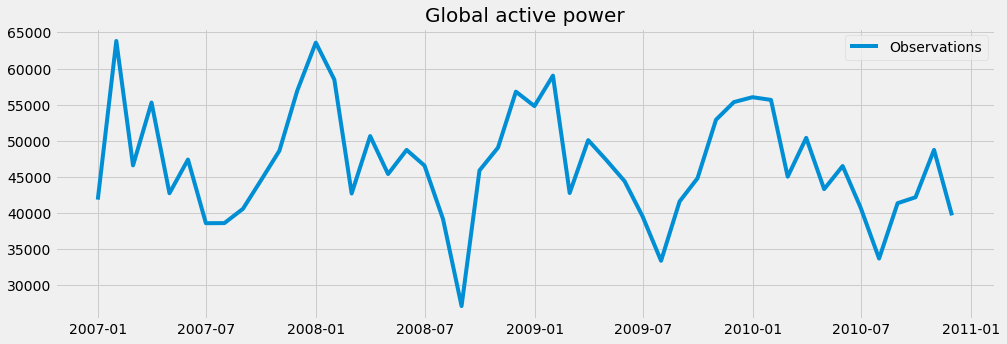

In [53]:
# pip install numpy==1.17.3 --user
# pip install --upgrade mxnet~=1.7 --user
# pip install gluonts --user

# Drop de 'Global_intensity' qui à 0.99 de corrélation avec 'Global_active_power'
df = data.drop(['Global_intensity'], axis=1)

# Sample par mois + S'arrêter en novembre 2010 car les données sont incomplètes en décembre 2010
monthly = df[:'2010-11-30'].resample('M').sum()
# monthly.tail()

plt.title('Global active power', size=20)
plt.plot(monthly['Global_active_power'], label='Observations')
plt.legend();

**Given a set of time series, you might ask various kinds of questions:**

* How will the time series evolve in the future? Forecasting
* Is the behavior of the time series in a given period abnormal? Anomaly detection
* Which group does a given time series belong to? Time series classification
* Some measurements are missing, what were their values? Imputation  

GluonTS allows you to address these questions by simplifying the process of building time series models, that is, mathematical descriptions of the process underlying the time series data. Numerous kinds of time series models have been proposed, and GluonTS focuses on a particular subset of these techniques based on deep learning.  

For this example, use the DeepAREstimator, which implements the DeepAR model proposed in the DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks paper. Given one or more time series, the model is trained to predict the next prediction_length values given the preceding context_length values. Instead of predicting single best values for each position in the prediction range, the model parametrizes a parametric probability distribution for each output position.

In [54]:
DeepAREstimator
# https://aws.amazon.com/fr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/

# Split train/test avec ListDataset de Gluonts

# To encapsulate models and trained model artifacts, 
# GluonTS uses an Estimator/Predictor pair of abstractions that should be familiar to users of other machine learning frameworks. 
# An Estimator represents a model that can be trained on a dataset to yield a Predictor, 
# which can later be used to make predictions on unseen data.
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
estimator = DeepAREstimator(freq="M", # The time series frequency
#                             context_length=24, # Le nombre de points temporels que le modèle doit voir avant de faire la prédiction. 
                            prediction_length=24, # The prediction length (24 time points, which makes it span 6 mois)
#                             num_layers=2,
#                             num_cells=64,
#                             cell_type='lstm',
                            batch_size=32,
                            trainer=Trainer(epochs=10))


# GluonTS provides a Dataset abstraction for providing uniform access to data across different input formats. 
# Here, use ListDataset to access data stored in memory as a list of dictionaries. 
# In GluonTS, any Dataset is just an Iterable over dictionaries mapping string keys to arbitrary values.

# Pour entraîner votre modèle, tronquez les données jusqu'en 2010. 
# Les données postérieures à cette date sont utilisées ultérieurement pour tester le modèle.
df_train = ListDataset([{"start":monthly.index[0], 'target':monthly.Global_active_power[:"2010"]}], freq="M")


# With the dataset in hand, you can now use your estimator and call its train method. 
# When the training process is finished, you have a Predictor that can be used for making forecasts.
predictor = estimator.train(training_data=df_train)

C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
100%|██████████| 50/50 [00:05<00:00,  9.20it/s, epoch=10/10, avg_epoch_loss=9.22]


In [13]:
DeepAREstimator

estimator = DeepAREstimator(freq="M",  
                            prediction_length=24, 
                            batch_size=32,
                            trainer=Trainer(epochs=10))

df_train = ListDataset([{"start":monthly.index[0], 'target':monthly.Global_active_power[:"2010"]}], freq="M")

predictor = estimator.train(training_data=df_train)

df_test = ListDataset(
    [
        {"start": monthly.index[0], "target": monthly.Global_active_power[:"2012"]}
    ],
    freq = "M"
)

C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq
  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
 58%|█████▊    | 29/50 [00:03<00:02,  9.45it/s, epoch=2/30, avg_epoch_loss=10.3]


KeyboardInterrupt: 

In [61]:
# Now use the predictor to plot the model’s forecasts on a few time ranges 
# that start after the last time point seen during training. 
# This is useful for getting a qualitative feel for the quality of the outputs produced by this model.

# Using the same base dataset as before, 
# create a few test instances by taking data past the time range previously used for training.

df_test = ListDataset(
    [
        {"start": monthly.index[0], "target": monthly.Global_active_power}
    ],
    freq = "M"
)

As you can see from the following plots, the model produces probabilistic predictions. This is important because it provides an estimate of how confident the model is, and allows downstream decisions based on these forecasts to account for this uncertainty.

C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


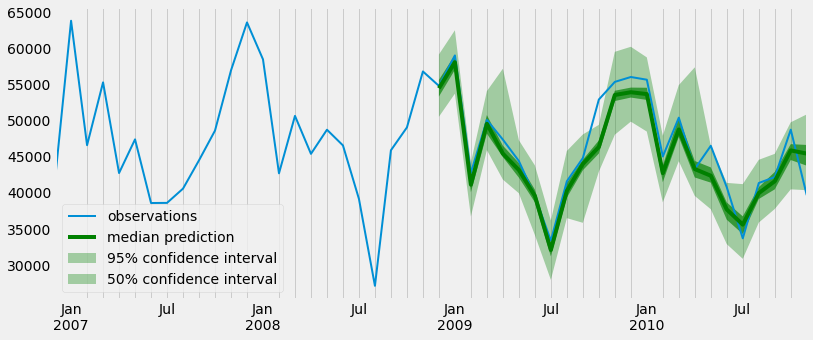

In [62]:
from itertools import islice

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        prediction_intervals = (50.0, 95.0)
        forecast.plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "95% confidence interval", "50% confidence interval"])
        plt.show()
        
forecast_it, ts_it = make_evaluation_predictions(df_test, predictor=predictor)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

In [32]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5])

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))
agg_metrics

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 76.95it/s]


{'MSE': 6036022.666666667,
 'abs_error': 40859.9453125,
 'abs_target_sum': 1108782.375,
 'abs_target_mean': 46199.265625,
 'seasonal_error': 5305.589518229167,
 'MASE': 0.3208875687620864,
 'MAPE': 0.039938939114411674,
 'sMAPE': 0.038852532704671226,
 'MSIS': 3.1651107927094624,
 'QuantileLoss[0.5]': 40859.9453125,
 'Coverage[0.5]': 0.5,
 'RMSE': 2456.831835243647,
 'NRMSE': 0.05317902356253411,
 'ND': 0.036851185799648016,
 'wQuantileLoss[0.5]': 0.036851185799648016,
 'mean_absolute_QuantileLoss': 40859.9453125,
 'mean_wQuantileLoss': 0.036851185799648016,
 'MAE_Coverage': 0.0,
 'OWA': nan}

In [52]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

        return list_of_df

NameError: name 'sagemaker' is not defined

In [46]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

NameError: name 'DeepARPredictor' is not defined

In [36]:
list_of_df = predictor.predict(monthly)
# actual_data = time_series[:5]

In [39]:
list_of_df

<generator object GluonPredictor.predict at 0x000002E82F4E21C8>

In [45]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

NameError: name 'prediction_length' is not defined

<Figure size 864x432 with 0 Axes>

In [56]:
start_date = '2010-12' # We want to predict first 30 days in 2010
timestamp = '00:00:00'
request_data = {
    'instances': [
        { 'start': '{} {}'.format(start_date, timestamp), 'target': [] }
    ],
    'configuration': {
        'num_samples': 50,
        'output_types': ['quantiles'],
        'quantiles': ['0.1', '0.5', '0.9']
    }
}

predictions_2010 = decode_prediction(predictor.predict(json.dumps(request_data).encode('utf-8')))

NameError: name 'decode_prediction' is not defined

In [ ]:
pd_series_2010 = pd.Series(data=mean_active_power_df.values[1112:],
                           index=pd.date_range(start=start_date,
                                               periods=len(mean_active_power_df.values[1112:]),
                                               freq=freq)
                          )

display_quantiles(predictions_2010, [pd_series_2010[0:prediction_length]])

C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\transform\split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
Running evaluation:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Utilisateur\anaconda3\envs\downgrade\lib\site-packages\gluonts\evaluation\_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 58.82it/s]


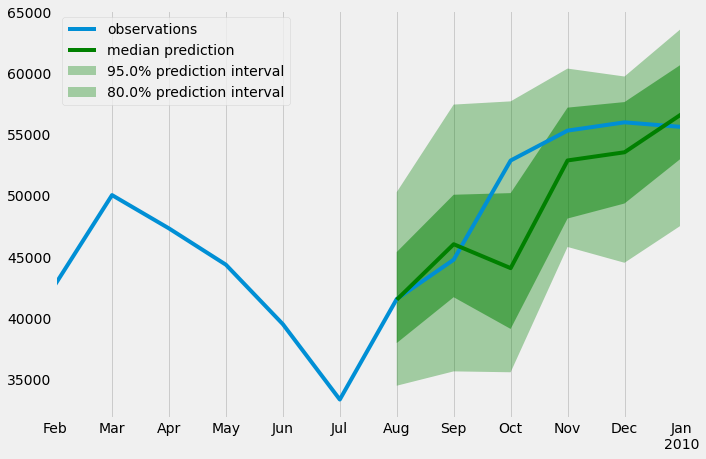

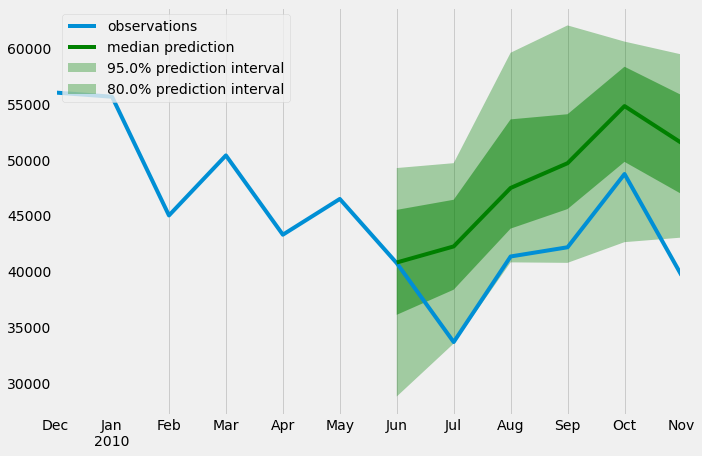

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,14344516.00,16062.97,306261.88,51043.65,4638.43,0.58,0.05,0.05,3.80,7369.94,0.00,16062.97,0.33,8364.53,0.83
1,NaN,56417482.67,40273.50,246208.88,41034.81,4234.04,1.59,0.17,0.15,9.70,35117.23,0.83,40273.50,1.00,13504.94,1.00


In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=df_test,  
    predictor=predictor,  
    num_samples=100,  
)

forecasts = list(forecast_it)
tss = list(ts_it)

# forecast_entry = forecasts[0]
# forecasts

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 12
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax) 
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()


evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(df_test))


plot_prob_forecasts(tss[0], forecasts[0])
plot_prob_forecasts(tss[1], forecasts[1])
item_metrics

In [ ]:
https://calvinfeng.gitbook.io/machine-learning-notebook/sagemaker/time_series_forecast